### Checking veg function after continental run from april 2020

#### current issues
https://prifysgolaber.sharepoint.com/:w:/r/sites/collaborate/land-cover-dea/_layouts/15/Doc.aspx?sourcedoc=%7B21ABC9CB-E8AC-4628-8F13-C70109F02F79%7D&file=Continental_run_review.docx&action=default&mobileredirect=true



##### problem identified: wcf threshold
1. WA bare areas
- Extensive agricultural area classified as bare  - previously recognised as agriculture in dec 2019 run
- Trace veg function through timeseries to identify the exact source of the problem 
- Likely an issue with consecutive count 
- tiles -14, -35 | -14, -36  | -13, -36

2. Veg consistency
- check exmouth gulf as very different for 2010 and 2015
- Just need to check veg function is operating correctly 
- Likely a dry/wet year correlation, however just check that it is the data causing this change and not the consecutive count function 

##### problem identified: consecutive count function (fixed) and wcf threshold
3. Tassie no data issues
- Potential no data issue as well as veg/non veg problem in west tassie rangelands (likely caused by low observations) 
- Similar issue east of Melbourne 
- tiles 11, -48 | 12,- 42 
- this is a no data issue, but getting bare surface due to not enough data for consecutive count function for veg,
these are very vegetated areas but we are making it reach a minimum to get to veg - perhaps we could also add a minimum to get to non veg?
- i think this could be a good idea, integrate to make non-veg also have > 2 months a year, otherwise call it no data

##### problem identified: wofs cannot pick up waterlogged veg areas
4. No natural aquatic vegetation (other than mangroves) 
- Problem exists because we mask out water at level 1 for vegetated product, only mangroves present 
- Run through level 1 and 2 and determine the problem more specifically 
- Check areas that did seem to classify NAV, maybe something to do with BS value being set to 100 in level 1? - check an extensive saltmarsh area as well 
- basically wofs cannot pick up waterlogged veg, even areas significantly waterlogged for extended periods of time

In [1]:
import os, sys, copy
import yaml
import numpy as np
import xarray as xr
import pickle

from itertools import groupby
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec

import datacube
from datacube.storage import masking
from datacube.virtual import catalog_from_file
dc = datacube.Datacube()

In [2]:
# AWS or Gadi
service = '/home/jovyan/development/'
# service = '/g/data/u46/users/bt2744/work/code/'

sys.path.append(str(service)+"dea-notebooks/Scripts")
from dea_classificationtools import sklearn_unflatten
from dea_classificationtools import sklearn_flatten

sys.path.append(os.path.abspath(str(service)+"livingearth_australia/le_plugins"))

In [3]:
# loading extents from yaml Dan prepared, just change site_name to tile interested in from our 16 test sites
yaml_sites_file = os.path.abspath(str(service)+"chris_leaust_testing/notebooks/misc/au_test_sites.yaml")

with open(yaml_sites_file, "r") as f:
    site_config = yaml.safe_load(f)

site_name = "SA - Strange NAV area"
extent_x = [site_config[site_name]["min_x"],
            site_config[site_name]["max_x"]]
extent_y = [site_config[site_name]["min_y"],
            site_config[site_name]["max_y"]]

crs = "EPSG:3577"
res = (-25, 25)
time = ("2010-01-01", "2010-12-31")
query =({'time': time,
             'x':extent_x,
            'y':extent_y,
            'crs':crs,
            'resolution':res})

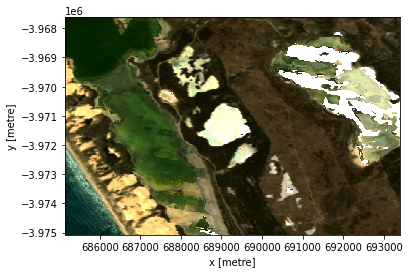

In [4]:
# Load Landsat
geomedian = dc.load(product="ls5_nbart_geomedian_annual", **query)
geomedian = masking.mask_invalid_data(geomedian).squeeze().drop('time')
geomedian[['red', 'green', 'blue']].to_array().plot.imshow(robust=True)

In [5]:
# datacube functions to load in a virtual product from recipe
catalog = catalog_from_file(service+'chris_leaust_testing/notebooks/misc/virtual_product_cat.yaml')

### vegetat_veg_cat

##### making fc_veg product
- should be identical to output from FC_summary plugin

In [6]:
# load fc wofs mask
product = catalog['ls_fc_wofs_masked']
ls_fc_wofs_masked = product.load(dc, **query)

# add water
product = catalog['wofs_daily']
wofs = product.load(dc, **query)
ls_fc_wofs_masked['water'] = wofs.water

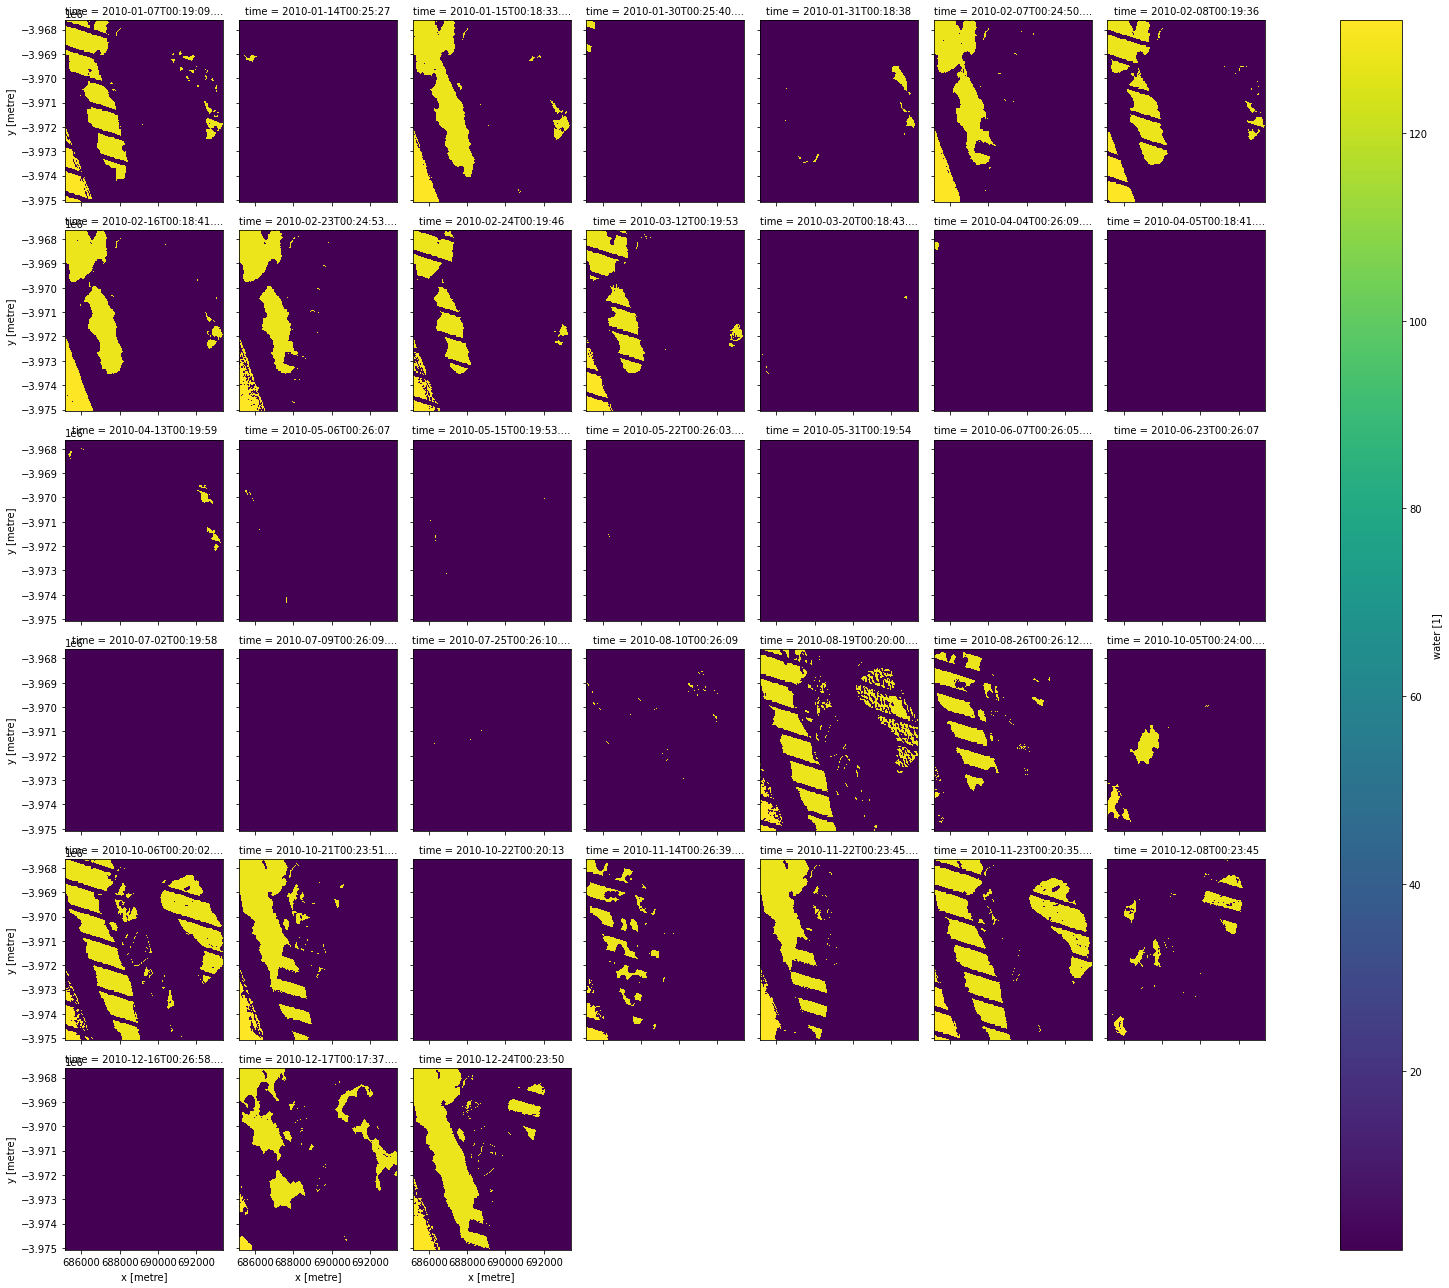

In [7]:
# ls_fc_wofs_masked.water.plot(col='time', col_wrap=7)
# ls_fc_wofs_masked.water
# Mask where clear water was observed in WOfS (128: clear and wet, 132: clear, wet & sea)
clearwater = ls_fc_wofs_masked.where(((ls_fc_wofs_masked['water'] == 128) | (ls_fc_wofs_masked['water'] == 132)), 1)

# no_water = np.invert( (data['water'] == 128) | (data['water'] == 132) )
clearwater.water.plot(col='time', col_wrap=7)

Text(0.5, 1.0, 'aquatic_wat')

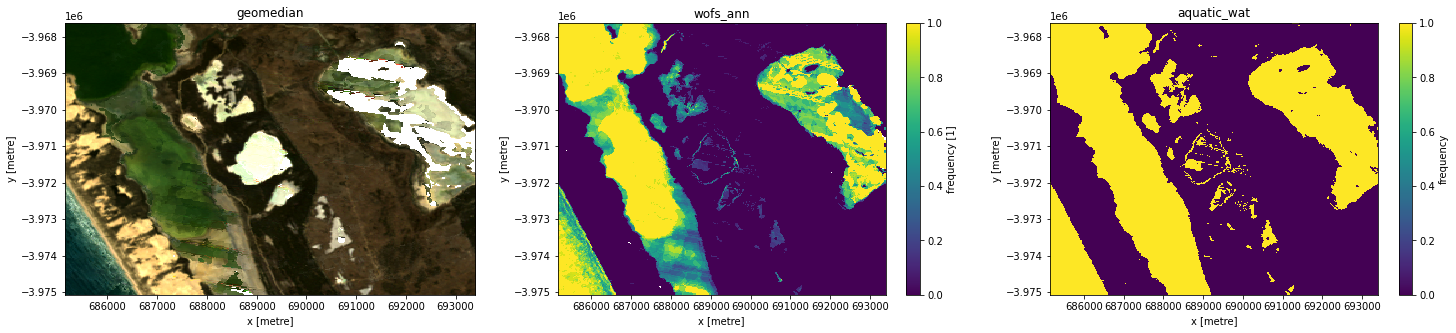

In [8]:
# Load wofs annual from datacube
wofs_ann = dc.load(product="wofs_annual_summary", measurements=["frequency"], **query)
wofs_ann = masking.mask_invalid_data(wofs_ann)
wofs_ann = wofs_ann.frequency
aquatic_wat = wofs_ann >= 0.1

plt.figure(figsize=(25,5))
gs = gridspec.GridSpec(1,3)

ax1=plt.subplot(gs[0,0])
geomedian[['red', 'green', 'blue']].to_array().plot.imshow(robust=True)
ax1.set_title('geomedian')

ax2=plt.subplot(gs[0,1])
wofs_ann.plot()
ax2.set_title('wofs_ann')

ax3=plt.subplot(gs[0,2])
aquatic_wat.plot()
ax3.set_title('aquatic_wat')

In [ ]:
### tasselled cap
sys.path.append(os.path.abspath(str(service)+"dea-notebooks/Scripts"))
import dea_bandindices

TC = dea_bandindices.calculate_indices(geomedian, index=['TCG', 'TCW', 'TCB'], collection='ga_ls_2', drop=True)


plt.figure(figsize=(25,5))
gs = gridspec.GridSpec(1,4)

ax1=plt.subplot(gs[0,0])
geomedian[['red', 'green', 'blue']].to_array().plot.imshow(robust=True)
ax1.set_title('geomedian')

ax2=plt.subplot(gs[0,1])
TC.TCG.plot()
ax2.set_title('greenness')

ax3=plt.subplot(gs[0,2])
TC.TCW.plot()
ax3.set_title('wetness')

ax4=plt.subplot(gs[0,3])
TC.TCB.plot()
ax4.set_title('brightness')

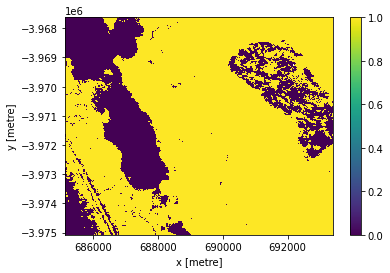

In [9]:
data = ls_fc_wofs_masked

def consecutive_count_veg(tv_numpy, consecutive_numpy, required_consecutive, consec_msk_val=1):
    '''
    function to get consective count of veg (1) for each pixel across the time series

    :param numpy.array tv_numpy: 3-D array of tv[z,y,x]
    :param numpy.array consecutive_numpy: bool output array for veg (1) and non veg (0)
    :param float required_consecutive: how many consectutive 1's to be classified as veg?
    :param float consec_msk_val: what value to calculcate consectutives on
           default is veg (1)     
    '''

    for y in range(tv_numpy.shape[1]):
        for x in range(tv_numpy.shape[2]):
            # If all the values are nan then just set output to nan and carry on
            pixel = tv_numpy[:,y,x]

            if np.all(np.isnan(pixel)):
                consecutive_numpy[y,x] = np.nan
                continue            

            # Get counts of consecutive veg classifications
            counts = [len(list(group)) for label, group in groupby(pixel[(~np.isnan(pixel))]) if label == 1]

            if not counts:
                consecutive_numpy[y,x] = 0
            elif max(counts) >= required_consecutive:
                consecutive_numpy[y,x] = 1
            else:
                consecutive_numpy[y,x] = 0

    return consecutive_numpy

def consecutive_count_nonveg(tv_numpy, consecutive_numpy, required_consecutive, consec_msk_val=1):
    '''
    function to get consective count of non veg (0) for each pixel across the time series

    :param numpy.array tv_numpy: 3-D array of tv[z,y,x]
    :param numpy.array consecutive_numpy: bool output array for veg (1) and non veg (0)
    :param float required_consecutive: how many consectutive 0's to be classified as non veg?
    :param float consec_msk_val: what value to calculcate consectutives on
           default is non veg (0)     
    '''

    for y in range(tv_numpy.shape[1]):
        for x in range(tv_numpy.shape[2]):
            # If all the values are nan then just set output to nan and carry on
            pixel = tv_numpy[:,y,x]

            if np.all(np.isnan(pixel)):
                consecutive_numpy[y,x] = np.nan
                continue            

            # Get counts of consecutive non veg classifications (hence label == 0)
            counts = [len(list(group)) for label, group in groupby(pixel[(~np.isnan(pixel))]) if label == 0]

            # Inversed values from consecutive_count_veg to make non veg
            if not counts:
                consecutive_numpy[y,x] = 1
            elif max(counts) >= required_consecutive:
                consecutive_numpy[y,x] = 0
            else:
                consecutive_numpy[y,x] = 1

    return consecutive_numpy

data_nan = masking.mask_invalid_data(data)

# Create water and low-quality fc masks
no_water = np.invert( (data['water'] == 128) | (data['water'] == 132) )
high_ue = (data['UE'] > 30) & no_water

# Set to null areas with high UE, but no water
data_nan = data_nan.where(np.invert(high_ue))

# Don't need this anymore
data_nan = data_nan.drop("UE")
del high_ue

# Where there's water, set PV to 0
data_nan['PV'] = data_nan.PV.where(no_water, 0)
data_nan['NPV'] = data_nan.NPV.where(no_water, 0)

# Where there's water, set BS to 100
data_nan['BS'] = data_nan.BS.where(no_water, 100)

# Don't need this anymore
data_nan = data_nan.drop("water")
del no_water

data_month = data_nan.groupby('time.month').median(dim='time')    

# Create mask where PV > BS
PV_dominant = data_month['PV'] > data_month['BS']
PV_dominant_nan = PV_dominant.where((data_month['PV'] >= 0) & (data_month['BS'] >= 0))

# Create mask where NPV > BS
NPV_dominant = data_month['NPV'] > data_month['BS']
NPV_dominant_nan = NPV_dominant.where((data_month['NPV'] >= 0) & (data_month['BS'] >= 0))

# Veg where PV or NPV are greater than BS
tv_mask = (PV_dominant_nan + NPV_dominant_nan)

# Make values of 2 == 1 (end result in binary veg mask)
tv_mask_drop = np.where(tv_mask == 2, 1, tv_mask)
tv_mask_xr = xr.DataArray(tv_mask_drop, coords=tv_mask.coords, dims=tv_mask.dims)

##### veg #####
# Executing consecutive_count function #
# veg and non veg = 2 consecutive months
required_consecutive = 2

# Pull tv as numpy array
tv_numpy = tv_mask_xr.values

# Set up array for output (faster to pre-allocate for numba).
# Needs to be float32 for NaN
consecutive_numpy = np.empty((tv_numpy.shape[1], tv_numpy.shape[2]), dtype=np.float32)

# For veg - run function to get array of with 1 where number of consecutive values for 
# different dates is >= required_consecutive
consecutive_numpy_veg = consecutive_count_veg(tv_numpy, consecutive_numpy, required_consecutive)

# Reduce original array to 2D
# using max here but not important as we just want to use shape/attributes
tv_reduce = tv_mask.max(dim='month')

# Create new data array with sampe dimensions as original
tv_summary_veg = xr.DataArray(consecutive_numpy_veg, coords=tv_reduce.coords, dims=tv_reduce.dims)  

tv_summary_veg.plot()

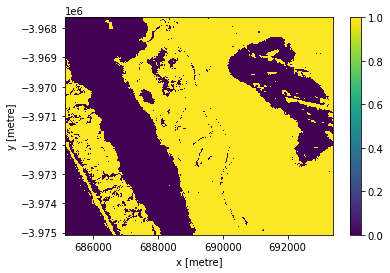

In [10]:
##### non veg #####
# Executing consecutive_count function #
# veg and non veg = 2 consecutive months
required_consecutive = 2        

# Pull tv as numpy array
tv_numpy = tv_mask_xr.values        

# Set up array for output (faster to pre-allocate for numba).
# Needs to be float32 for NaN
consecutive_numpy = np.empty((tv_numpy.shape[1], tv_numpy.shape[2]), dtype=np.float32)

# For non veg - run function to get array of with 0 where number of consecutive values for 
# different dates is >= required_consecutive
consecutive_numpy_nonveg = consecutive_count_nonveg(tv_numpy, consecutive_numpy, required_consecutive)

# Reduce original array to 2D
# using max here but not important as we just want to use shape/attributes
tv_reduce = tv_mask.max(dim='month')

# Create new data array with sampe dimensions as original
tv_summary_nonveg = xr.DataArray(consecutive_numpy_nonveg, coords=tv_reduce.coords, dims=tv_reduce.dims)

tv_summary_nonveg.plot()

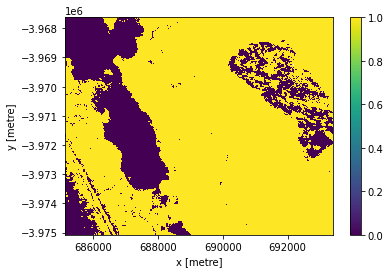

In [11]:
## Combine veg and non veg masks (to ensure no data is correctly identified)
tv_combine = tv_summary_veg + tv_summary_nonveg

# Make values of 2 == 1 (end result in binary veg mask)
tv_combine_drop = np.where(tv_combine == 2, 1, tv_combine)

# Create new data array with sampe dimensions as original
tv_summary = xr.DataArray(tv_combine_drop, coords=tv_reduce.coords, dims=tv_reduce.dims)

tv_summary.plot()

In [ ]:
tv_mask_xr.plot(col='month', col_wrap=4)

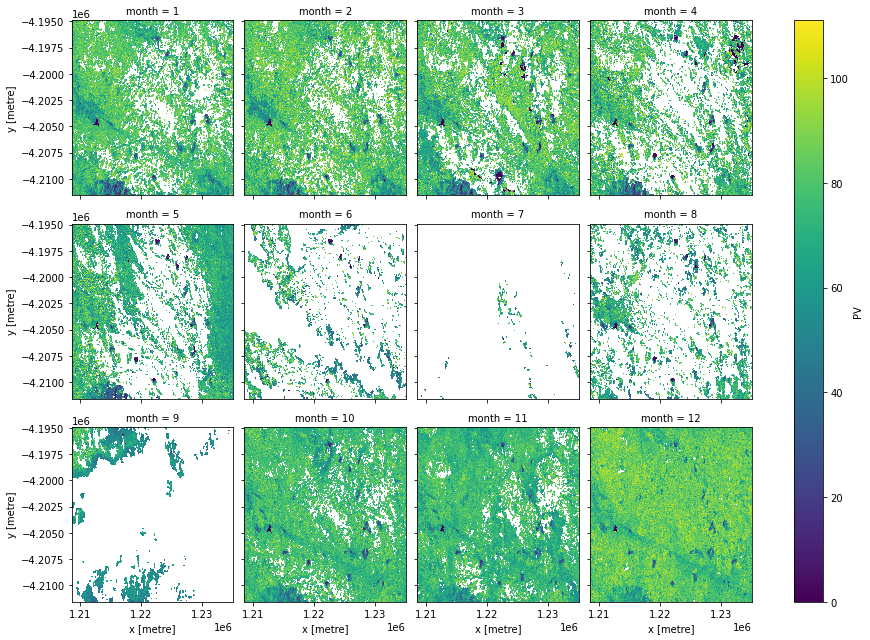

In [37]:
data_month.PV.plot(col='month', col_wrap=4)
# data_nan.PV.plot(col='time', col_wrap=4)

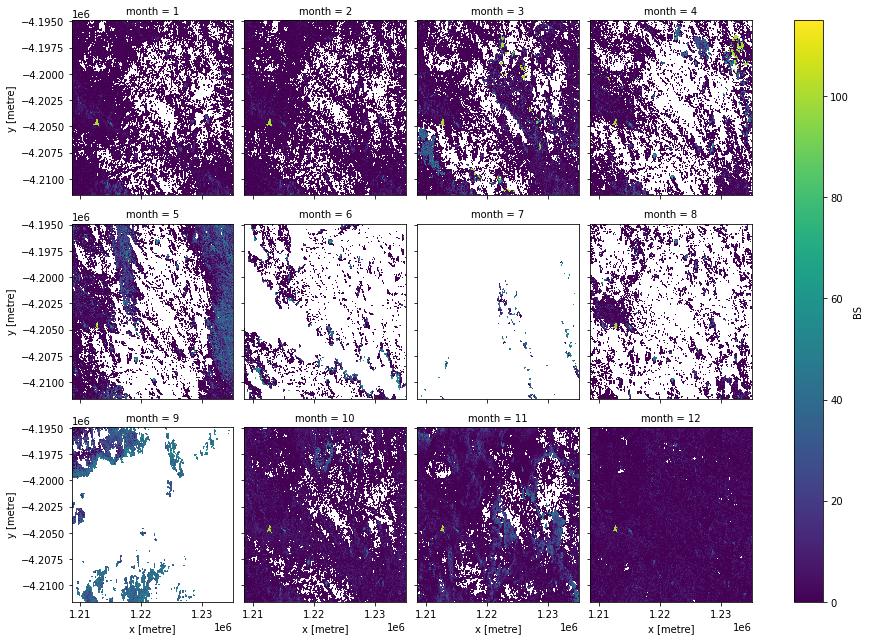

In [38]:
data_month.BS.plot(col='month', col_wrap=4)
# data_nan.BS.plot(col='time', col_wrap=4)

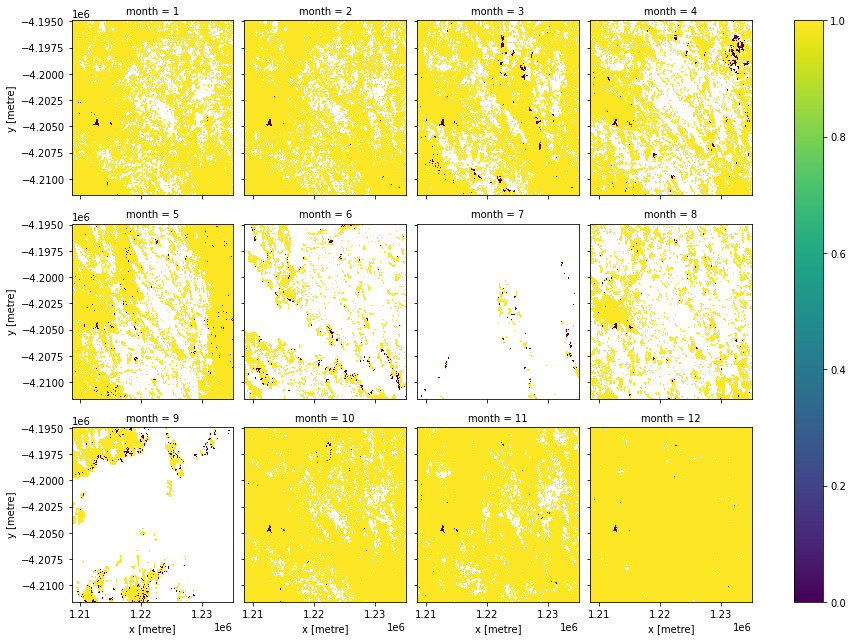

In [39]:
tv_mask_xr.plot(col='month', col_wrap=4)

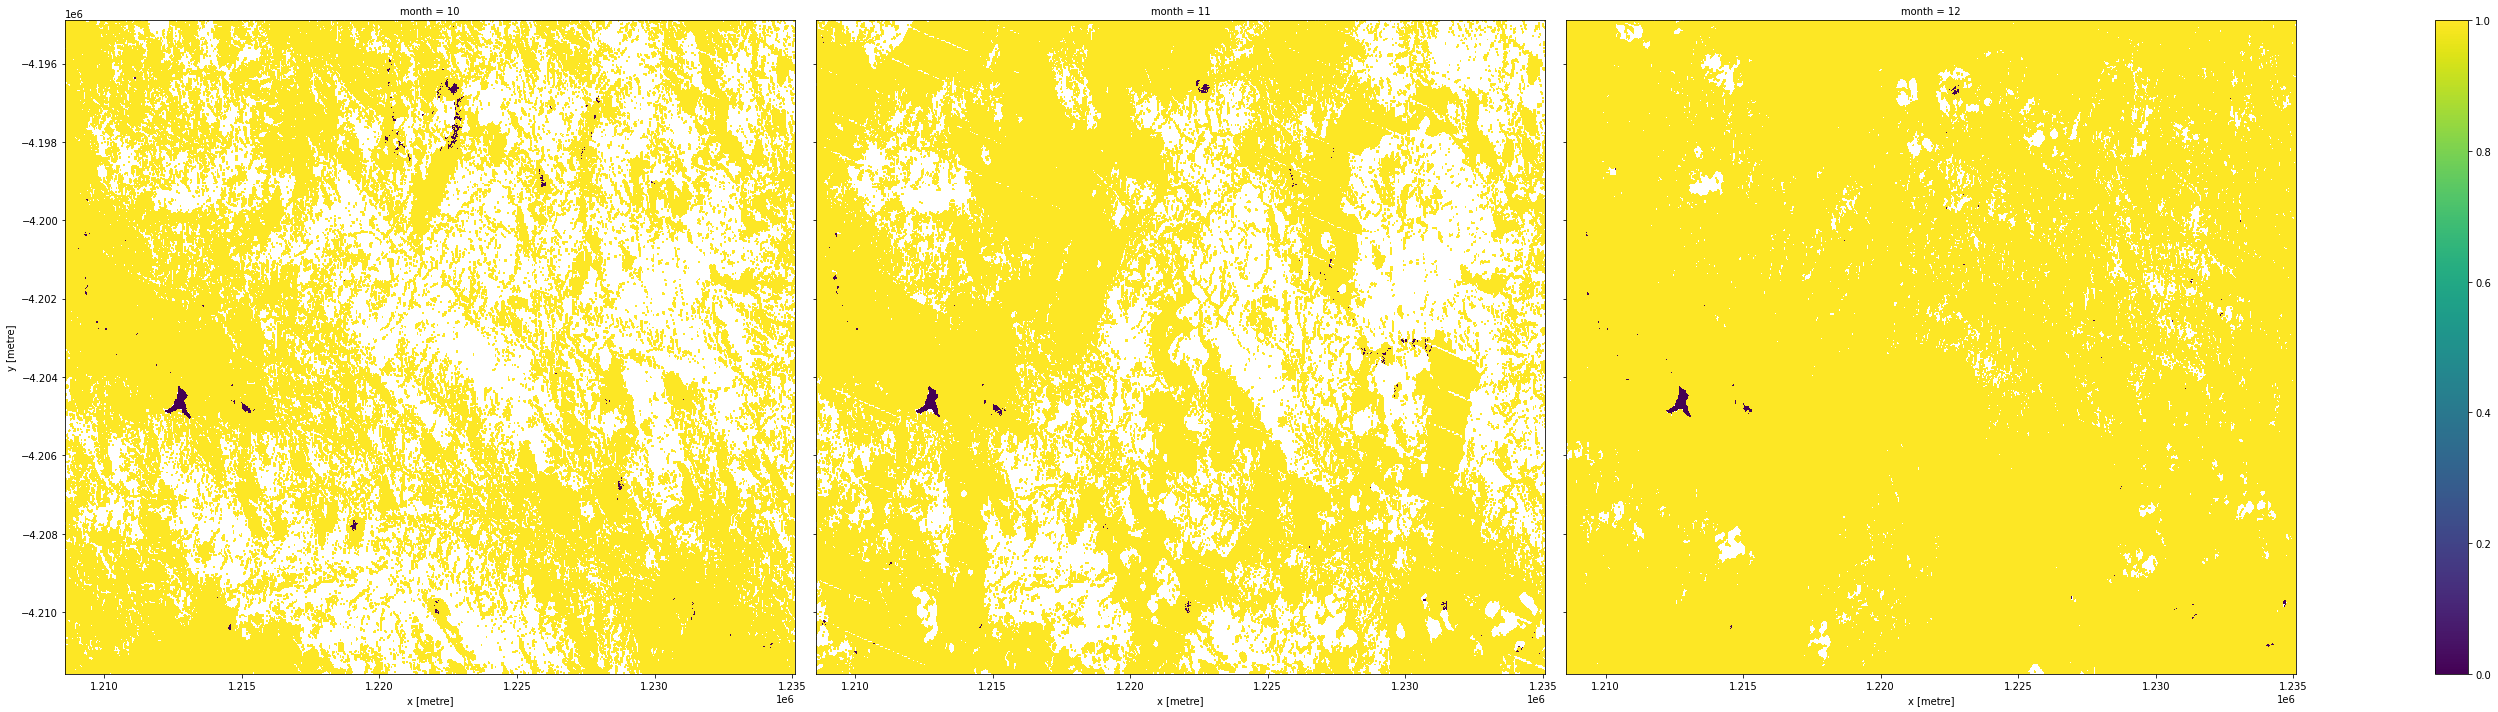

In [89]:
# tv_mask_xr.sel(month='1')

# tv_mask_xr.sel(month=slice('10', '11'))
tv_mask_xr[9:12].plot(col='month', col_wrap=3,figsize=(40,10))

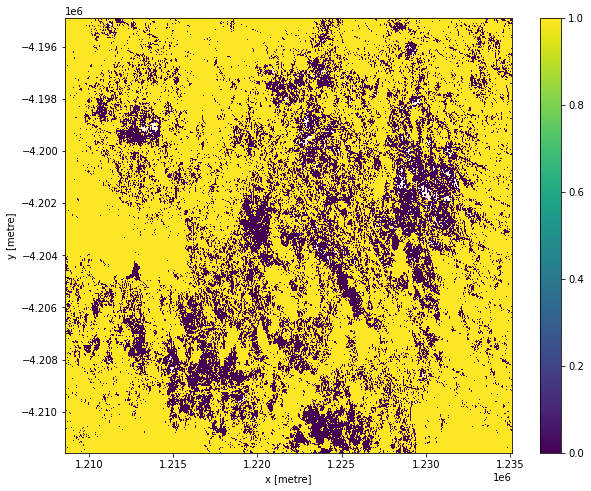

In [87]:
fc_veg.plot(figsize=(10,8))

##### making wofs_mask product

In [12]:
# Load data from datacube
wofs_ann = dc.load(product="wofs_annual_summary", measurements=["frequency"], **query)
wofs_mask = 1-((wofs_ann["frequency"] >= 0.2)).squeeze().drop('time')

##### making wcf_mask product
- should be identical to output from wcf_mask plugin

In [13]:
# load fc wofs mask
product = catalog['best_pixel_gm']
best_pixel_gm = product.load(dc, **query)

In [14]:
data = best_pixel_gm

model_pickle = str(service)+'livingearth_australia/models/wcf_model.pickle'

"""
Takes an existing model saved out as a pickle file.
"""
# Unpickle model
with open(model_pickle, "rb") as f:
    ml_model_dict = pickle.load(f)

flat = sklearn_flatten(data)
flat = flat/10000
results = ml_model_dict.predict(flat)
predicted_wcf = (sklearn_unflatten(results,data).transpose())[0]

# Currently copying and making a dataset with same size
# Make a deep copy
wcf_mask = copy.deepcopy(predicted_wcf)

# Make an array of zeroes
wcf_mask.values = np.zeros_like(predicted_wcf, dtype='float64')

# Using model to predict woody cover fraction trained on Albert Van Dijk's data
# masking values <= 0.004 as non veg
wcf_mask.values = np.where(predicted_wcf >= 0.004, 1, wcf_mask.values)


/env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.ensemble.forest module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)
/env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.tree.tree module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.tree. Anything that cannot be imported from sklearn.tree is now part of the private API.
  warnings.warn(message, FutureWarning)
/env/lib/python3.6/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.21.3 when using version 0.22.2.post1. This might lead to breaking code or invalid

##### display input for vegetat_veg_cat

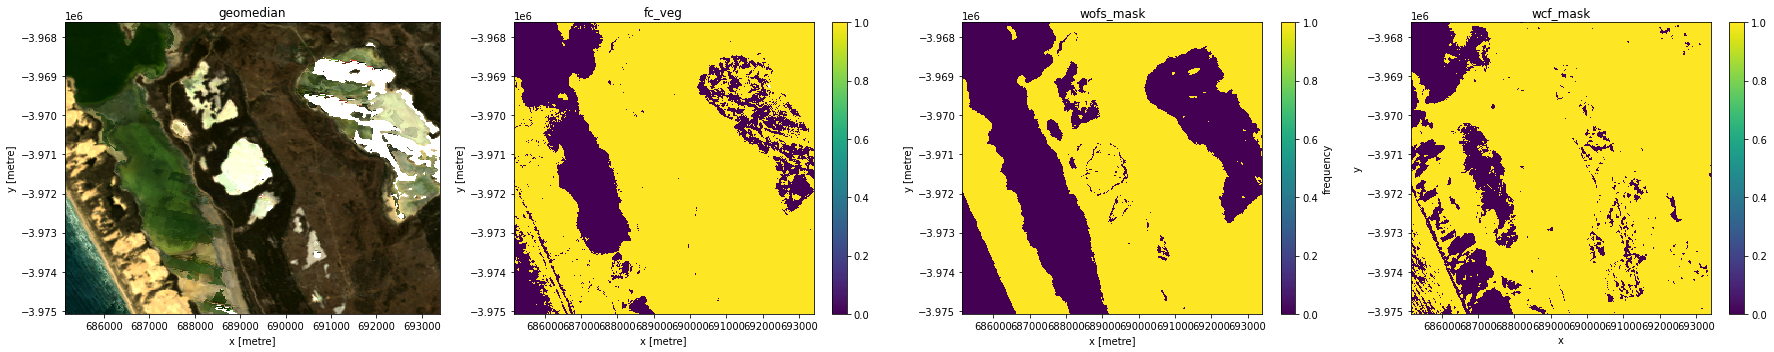

In [15]:
plt.figure(figsize=(25,5))
gs = gridspec.GridSpec(1,4)

ax1=plt.subplot(gs[0,0])
geomedian[['red', 'green', 'blue']].to_array().plot.imshow(robust=True)
ax1.set_title('geomedian')

ax2=plt.subplot(gs[0,1])
tv_summary.plot.imshow()
ax2.set_title('fc_veg')

ax3=plt.subplot(gs[0,2])
wofs_mask.plot.imshow()
ax3.set_title('wofs_mask')

ax4=plt.subplot(gs[0,3])
wcf_mask.plot.imshow()
ax4.set_title('wcf_mask')

plt.tight_layout()
plt.show()

##### display output for vegetat_veg_cat

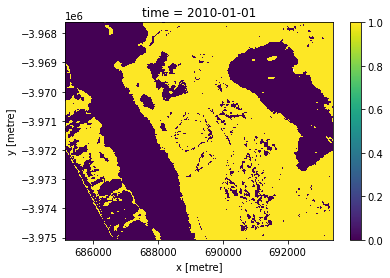

In [16]:
vegetat_veg_cat = tv_summary * wofs_mask * wcf_mask
vegetat_veg_cat.plot()